In [23]:
from Utilities import *
import torch

import h5py
import pandas as pd
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def plot_abp(abp_data):

   # Plotting the two 1D arrays with different colors
    plt.figure(figsize=(10, 6))
    plt.plot(abp_data, label='ABP Data')
    plt.grid(True)
    plt.show()

In [3]:
hdf5_file_path = '/home/ms5267@drexel.edu/moberg-precicecap/data/Patient_2021-12-21_04_16.h5'
annotation_path = '/home/ms5267@drexel.edu/moberg-precicecap/data/20240207-annotations-export-workspace=precicecap-patient=7-annotation_group=90.csv'
annotation_metadata = {
    'modality':'ART'
    ,'location':'na'
    ,'scale_wrt_hd5':1e3
}
segment_length_sec = 3

data_group_name='Waveforms/ART_na'
timestamp_group_name='Waveforms/ART_na_Timestamps'
sampling_frequency=125

df_annotation = pd.read_csv(annotation_path)
df_annotation_filtered = df_annotation[(df_annotation['modality']==annotation_metadata['modality']) & (df_annotation['location']==annotation_metadata['location'])]

artifacts = df_annotation_filtered[["start_time","end_time"]].to_numpy() * int(annotation_metadata['scale_wrt_hd5'])

In [4]:
with h5py.File(hdf5_file_path, 'r') as file:
    dataset = file[data_group_name]
    timestamp = file[timestamp_group_name]

    data, timestamp = dataset[:], timestamp[:]

In [8]:
artifact_raw = []
for art in artifacts:
	start_idx = np.searchsorted(timestamp, art[0], side='left')
	end_idx = np.searchsorted(timestamp, art[1], side='left')
	# For 125Hz, the sample_len is 1250 for 10sec sample
	##################################################

	interval_data = data[start_idx:end_idx]
	artifact_raw.append(interval_data)
	

In [17]:
# Now filter the artifacts whose more than 50% data is less than zero
# Calculate the percentage < 0 in the array
artifact_raw_clean = []
for arr in artifact_raw:
	percentage = (np.sum(arr < 0) / arr.size) * 100

	# Check if the percentage is greater than 30%
	if percentage >= 50:
		count_less_than_zero = np.sum(arr < 0)
		print(f"Out of {arr.shape}, {count_less_than_zero} are negative values")
	else:
		artifact_raw_clean.append(arr)
    

Out of (7496,), 5140 are negative values
Out of (915701,), 855434 are negative values
Out of (1874,), 1202 are negative values
Out of (4997,), 3261 are negative values


/tmp/ipykernel_416966/707838372.py:5: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (np.sum(arr < 0) / arr.size) * 100


In [28]:
def get_pulses(signal, sigma=2):
	filtered_signal = gaussian_filter1d(signal, sigma=sigma)

	troughs, _ = scipy.signal.find_peaks(-filtered_signal)
	pulses = []
	for i in range(len(troughs)-1):
		pulses.append(signal[troughs[i]:troughs[i+1]])
	
	return pulses
    

In [34]:
def interpolate_and_normalize(signal):
	# Original indices
	x_original = np.arange(len(signal))

	# New indices for the desired length of 64
	x_new = np.linspace(0, len(signal) - 1, 64)

	# Perform cubic spline interpolation
	cs = scipy.interpolate.CubicSpline(x_original, signal)
	interpolated_array = cs(x_new)

	# Normalize the interpolated array to have values between 0 and 1
	normalized_array = (interpolated_array - interpolated_array.min()) / (interpolated_array.max() - interpolated_array.min())

	return normalized_array

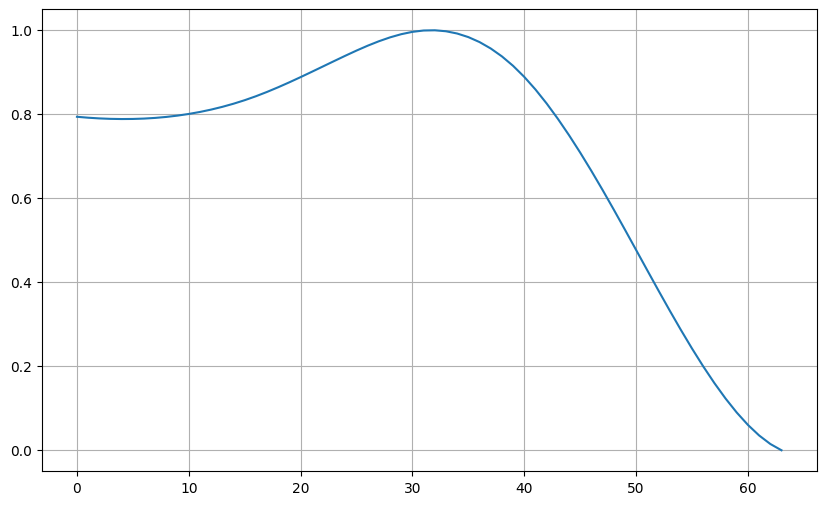

In [38]:
signal = artifact_raw_clean[1]
pulses = get_pulses(signal)

d = interpolate_and_normalize(pulses[1])
